In [1]:
import sys
import imageio
%load_ext autoreload
%autoreload 2

# sys.path.append('RoMa/romatch')

import cv2
import torch
import pycolmap
import os
import h5py
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
import numpy as np

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cpu')



## Download example data

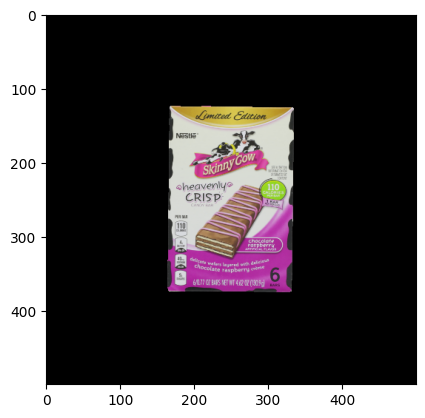

In [2]:
dirname = 'Nestl_Skinny_Cow_Heavenly_Crisp_Candy_Bar_Chocolate_Raspberry_6_pack_462_oz_total'
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.png' in x][:-11]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

## roma Matching

In [4]:

import torchvision
from pathlib import Path
from romatch import roma_outdoor, roma_indoor
def get_unique_idxs(A, dim=1):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=dim, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted, = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies


def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout_roma',
                   device=torch.device('cpu'),
                   min_matches=15, resize_to_ = (640, 480)):


    roma_model = roma_outdoor(device=device)
    
    Path(feature_dir).mkdir(exist_ok=True)
    with h5py.File(f'{feature_dir}/matches_roma.h5', mode='w') as f_match:
        for i, pair_idx in enumerate(index_pairs):
            print(f'Processing pair {i+1}/{len(index_pairs)}')
            idx1, idx2 = pair_idx
            fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
            key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
            # Load img1
            timg1 = load_torch_image(fname1, device=device)
            H1, W1 = timg1.shape[2:]
            if H1 < W1:
                resize_to = resize_to_[1], resize_to_[0]
            else:
                resize_to = resize_to_
            timg_resized1 = K.geometry.resize(timg1, resize_to, antialias=True)
            h1, w1 = timg_resized1.shape[2:]

            # Load img2
            timg2 = load_torch_image(fname2, device=device)
            H2, W2 = timg2.shape[2:]
            if H2 < W2:
                resize_to2 = resize_to[1], resize_to[0]
            else:
                resize_to2 = resize_to_
            timg_resized2 = K.geometry.resize(timg2, resize_to2, antialias=True)
            h2, w2 = timg_resized2.shape[2:]
            with torch.inference_mode():
                
                # img_A_path = 'A.png'
                # img_B_path = 'B.png' 
                # 
                # imageio.v3.imwrite(img_A_path, (timg_resized1.squeeze().permute(1, 2, 0) * 255).to(torch.uint8).numpy(force=True))
                # imageio.v3.imwrite(img_B_path, (timg_resized2.squeeze().permute(1, 2, 0) * 255).to(torch.uint8).numpy(force=True))
                img_A = torchvision.transforms.functional.to_pil_image(timg_resized1.squeeze())
                img_B = torchvision.transforms.functional.to_pil_image(timg_resized2.squeeze())
                
                warp, certainty = roma_model.match(img_A, img_B, device=device)
                matches, certainty = roma_model.sample(warp, certainty)
                
            kptsA, kptsB = roma_model.to_pixel_coordinates(matches, h1, w1, h2, w2)
            
            mkpts0 = kptsA.numpy(force=True)
            mkpts1 = kptsB.numpy(force=True)
            
            # mkpts0 = correspondences['keypoints0'].cpu().numpy()
            # mkpts1 = correspondences['keypoints1'].cpu().numpy()

            mkpts0[:,0] *= float(W1) / float(w1)
            mkpts0[:,1] *= float(H1) / float(h1)

            mkpts1[:,0] *= float(W2) / float(w2)
            mkpts1[:,1] *= float(H2) / float(h2)
            
            # Custom condition to filter out matches based on pixel values
            valid_matches = []
            for pt0, pt1 in zip(mkpts0, mkpts1):
                x1, y1 = int(pt0[0]), int(pt0[1])
                x2, y2 = int(pt1[0]), int(pt1[1])
            
                # Retrieve pixel values from original images (assuming grayscale, adjust if RGB)
                pixel_value_img1 = timg1[0, 0, y1, x1].item()  # Pixel in image1 at (x1, y1)
                pixel_value_img2 = timg2[0, 0, y2, x2].item()  # Pixel in image2 at (x2, y2)
            
                # Condition to check pixel values (modify the threshold as needed)
                if (pixel_value_img1 > 1e-4) and (pixel_value_img2 > 1e-4):
                    valid_matches.append((pt0, pt1))
            
            # Unpack valid matches into separate mkpts0 and mkpts1 arrays
            mkpts0 = np.array([match[0] for match in valid_matches])
            mkpts1 = np.array([match[1] for match in valid_matches])

            n_matches = len(mkpts1)
            group  = f_match.require_group(key1)
            if n_matches >= min_matches:
                 group.create_dataset(key2, data=np.concatenate([mkpts0, mkpts1], axis=1))
    # Let's find unique roma pixels and group them together
    kpts = defaultdict(list)
    match_indexes = defaultdict(dict)
    total_kpts=defaultdict(int)
    with h5py.File(f'{feature_dir}/matches_roma.h5', mode='r') as f_match:
        for k1 in f_match.keys():
            group  = f_match[k1]
            
            for k2 in group.keys():
                matches = group[k2][...]
                total_kpts[k1]
                kpts[k1].append(matches[:, :2])
                kpts[k2].append(matches[:, 2:])
                current_match = torch.arange(len(matches)).reshape(-1, 1).repeat(1, 2)
                current_match[:, 0]+=total_kpts[k1]
                current_match[:, 1]+=total_kpts[k2]
                total_kpts[k1]+=len(matches)
                total_kpts[k2]+=len(matches)
                match_indexes[k1][k2]=current_match
    for k in kpts.keys():
        kpts[k] = np.round(np.concatenate(kpts[k], axis=0))
    unique_kpts = {}
    unique_match_idxs = {}
    out_match = defaultdict(dict)
    for k in kpts.keys():
        uniq_kps, uniq_reverse_idxs = torch.unique(torch.from_numpy(kpts[k]),dim=0, return_inverse=True)
        unique_match_idxs[k] = uniq_reverse_idxs
        unique_kpts[k] = uniq_kps.numpy()
    for k1, group in match_indexes.items():
        for k2, m in group.items():
            m2 = deepcopy(m)
            m2[:,0] = unique_match_idxs[k1][m2[:,0]]
            m2[:,1] = unique_match_idxs[k2][m2[:,1]]
            mkpts = np.concatenate([unique_kpts[k1][ m2[:,0]],
                                    unique_kpts[k2][  m2[:,1]],
                                   ],
                                   axis=1)
            unique_idxs_current = get_unique_idxs(torch.from_numpy(mkpts), dim=0)
            m2_semiclean = m2[unique_idxs_current]
            unique_idxs_current1 = get_unique_idxs(m2_semiclean[:, 0], dim=0)
            m2_semiclean = m2_semiclean[unique_idxs_current1]
            unique_idxs_current2 = get_unique_idxs(m2_semiclean[:, 1], dim=0)
            m2_semiclean2 = m2_semiclean[unique_idxs_current2]
            out_match[k1][k2] = m2_semiclean2.numpy()
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp:
        for k, kpts1 in unique_kpts.items():
            f_kp[k] = kpts1
    
    with h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for k1, gr in out_match.items():
            group  = f_match.require_group(k1)
            for k2, match in gr.items():
                group[k2] = match
    return

                    

xFormers not available


In [3]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        if i == j - 1 or True:
            index_pairs.append((i,j))


In [5]:
feature_dir = '.featureout_roma'
dev=torch.device('mps')
dev=torch.device('cpu')
match_features(img_fnames, index_pairs, feature_dir = feature_dir, device=dev)

/home/tom/anaconda3/envs/imc2023-kornia-starter-pack/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tom/anaconda3/envs/imc2023-kornia-starter-pack/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (864, 864)
Processing pair 1/55



KeyboardInterrupt



## Import into colmap and run reconstruction

In [12]:
from h5_to_db import add_keypoints, add_matches, COLMAPDatabase

def import_into_colmap(img_dir,
                       feature_dir ='.featureout',
                       database_path = 'colmap.db',
                       img_ext='.jpg'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, img_ext, 'simple-radial', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )

    db.commit()
    return

database_path = 'colmap_roma_backup.db'
!rm {database_path}
import_into_colmap(dirname,feature_dir=feature_dir, database_path=database_path)

  0%|          | 0/11 [5:51:25<?, ?it/s]


KeyboardInterrupt: 

In [8]:

def run_reconstruction(image_dir, output_path = 'colmap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    maps = pycolmap.incremental_mapping(database_path, dirname, output_path)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
    maps[0].write(output_path)
    return maps

In [9]:
output_path = './output'
maps = run_reconstruction(dirname, output_path, database_path)

I20241105 19:00:55.092240 128392496113344 misc.cc:198] 
Feature matching
I20241105 19:00:55.093091 128392504506048 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.093444 128392806495936 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.093609 128392546453184 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.093782 128392756188864 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.094103 128392747796160 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.094148 128388422657728 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.094187 128392672294592 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.094194 128392588400320 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.094288 128392630347456 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.094314 128388400375488 sift.cc:1457] Creating SIFT CPU feature matcher
I20241105 19:00:55.094547 1

In [10]:
!glomap mapper --database_path ./colmap_roma.db --output_path ./output --image_path ./{dirname}


 Loading Images 11 / 11
 Loading Image Pair 55 / 55
I20241105 19:02:23.881265 114948 colmap_converter.cc:303] Pairs read done. 0 / 55 are invalid
I20241105 19:02:23.881637 114948 global_mapper.cc:80] Loaded database
-------------------------------------
Running preprocessing ...
-------------------------------------
I20241105 19:02:23.881757 114948 view_graph_manipulation.cc:249] Decompose relative pose for 0 pairs
I20241105 19:02:23.882666 114948 view_graph_manipulation.cc:303] Decompose relative pose done. 0 pairs are pure rotation
I20241105 19:02:23.883345 114948 timer.cc:87] Elapsed time: 0.00169 [seconds]
-------------------------------------
Running view graph calibration ...
-------------------------------------
I20241105 19:02:23.883366 114948 view_graph_calibration.cc:16] Start ViewGraphCalibrator
I20241105 19:02:23.906256 114948 view_graph_calibration.cc:148] 3 cameras are rejected in view graph calibration
I20241105 19:02:23.906354 114948 view_graph_calibration.cc:182] inval

## Visualize with colmap GUI (yes, it is cheating)